<center><b><font size=6>Supervised learning – classification<b><center>

This notebook implements the supervised learning component of the SSH Shell Attack session project. The goal is to classify attack session tactics based on the provided dataset.

0. **Install Dependencies**
1. **Data Splitting**
2. **Baseline Model Implementation**
3. **Hyperparameter Tuning**
4. **Result Analysis**  
5. **Feature Experimentation**

<center><b><font size=5>Install Dependencies<b><center>

In [1]:
!python ../scripts/install_dependencies.py section2

Installing common packages: pandas, pyarrow
  Using cached pyarrow-12.0.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (39.1 MB)
Installing Section 2 packages: matplotlib, seaborn, scikit-learn


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import sys
sys.path.append('../')

from scripts.data_processing import sampling, split_train_test
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix
)
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputClassifier

<center><b><font size=5>Data Splitting<b><center>

Split the dataset into training and testing sets.

"Perform a split to segment the dataset into training and test dataset.
If you want to standardize your dataset, fit the scaler on training set and transforming both training
and test. Notice that the sklearn implementation of tf-idf already performs the standardization."

**Steps:**

- Data Loading
- Data Splitting
- Multi-Label Transformation
- Summary

### Load the dataset

- Loads the dataset from a Parquet file into a Pandas DataFrame.

In [3]:
# Dataset intero
SSH_Attacks = pd.read_parquet("../data/processed/ssh_attacks_decoded.parquet")
#SSH_Attacks

In [4]:
SSH_Attacks_bow_sampled = pd.read_parquet("../data/processed/BOW_DATASETS/ssh_attacks_bow_sampled.parquet")
#SSH_Attacks_bow_sampled

In [5]:
SSH_Attacks_tfidf = pd.read_parquet("../data/processed/TFIDF_DATASETS/ssh_attacks_tfidf.parquet")
#SSH_Attacks_tfidf_sampled

### Data Splitting

- Define Features (X) and Labels (y)
- Split Data into Training and Testing Sets
- Preprocess Text Data
- Vectorize Text with TF-IDF


_Suggestions:_

- _point 1. Validate that full_session and Set_Fingerprint do not have null values using: print(X.isnull().sum(), y.isnull().sum())_
- _point 2. Stratify the split if the label distribution is imbalanced using: train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)_
- _point 2. Check the distribution of labels in training and test sets._
- _point 3. Add a basic cleaning step if the text contains unwanted characters or casing._
- _point 4. Explore hyperparameters like ngram_range, min_df, and max_df to see their effect on performance._
- _point 4. Use stop_words='english' to remove common but non-informative words._

In [6]:
# Dataset 100%
# X = SSH_Attacks['full_session']  # Text data
# y = SSH_Attacks['Set_Fingerprint']  # Multi-label target

# Campiona il 5% del dataset
SSH_Attacks_sampled = sampling(SSH_Attacks, 2, 0.05)

# Separazione delle caratteristiche (X) e del target (y)
X = SSH_Attacks_sampled['full_session']  # Text data
y = SSH_Attacks_sampled['Set_Fingerprint']  # Multi-label target

# Ensure a 70/30 split while maintaining reproducibility (random_state=42).
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Convert to strings to ensure compatibility with TfidfVectorizer
X_train = X_train.astype(str)
X_test = X_test.astype(str)

# Vectorize the text data using TF-IDF (standardization is included in TF-IDF by default)
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Controllo delle dimensioni dei dati vettorizzati
print(f"Train set TF-IDF shape: {X_train_tfidf.shape}")
print(f"Test set TF-IDF shape: {X_test_tfidf.shape}")

Train set TF-IDF shape: (163124, 66)
Test set TF-IDF shape: (69911, 66)


### Multi-Label Transformation

- Transform Labels to Binary Format


_Suggestions:_

- _Check for any inconsistencies in label transformation: print(y_train_binary.head(), y_test_binary.head())_
- _Verify that `mlb.classes` matches the expected categories._

In [7]:
# Fit the MultiLabelBinarizer on the training set labels only
mlb = MultiLabelBinarizer()
mlb.fit(y_train)

# Transform the training and test labels into binary matrices
y_train_binary = pd.DataFrame(mlb.transform(y_train), columns=mlb.classes_, index=y_train.index)
y_test_binary = pd.DataFrame(mlb.transform(y_test), columns=mlb.classes_, index=y_test.index)

### Summary

- Ensures the processed data is correctly prepared for modeling.


_Suggestions:_

- _Check the sparsity of X_train_tfidf and X_test_tfidf: print("Train Sparsity:", (X_train_tfidf.nnz / np.prod(X_train_tfidf.shape)) * 100) print("Test Sparsity:", (X_test_tfidf.nnz / np.prod(X_test_tfidf.shape)) * 100)_

In [8]:
# Print basic info about the processed data
print("\nProcessed Training set size:", len(X_train))
print("\nProcessed Testing set size:", len(X_test))
print("\nShape of y_train_binary:", y_train_binary.shape)
print("\nShape of y_test_binary:", y_test_binary.shape)
print("\nClasses:", mlb.classes_)


Processed Training set size: 163124

Processed Testing set size: 69911

Shape of y_train_binary: (163124, 7)

Shape of y_test_binary: (69911, 7)

Classes: ['Defense Evasion' 'Discovery' 'Execution' 'Harmless' 'Impact' 'Other'
 'Persistence']


<center><b><font size=5>Baseline Model Implementation<b><center>

Train at least two ML models and evaluate their performance.

"Choose at least 2 ML methods, and perform the model training, with default parameter
configuration, evaluating the performance on both training and test set. Output the confusion
matrix and classification report. Do you observe overfitting or under-fitting? Which model
generates the best performance?"

**Steps:**

- Choose different ML models (e.g., Logistic Regression and Random Forest).
- Logistic Regression - Training and Evaluation.
- Random Forest - Training and Evaluation.
- Support Vector Machine (SVM) - Training and Evaluation.
- Compare performance and check for overfitting/underfitting.

### Choose and initialize models

- text

In [9]:
# Initialize models with OneVsRestClassifier for multilabel classification
models = {
    "Logistic Regression": OneVsRestClassifier(LogisticRegression(max_iter=1000, random_state=42)),
    "Random Forest": OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42)),
    "SVM": OneVsRestClassifier(SVC(kernel='linear', random_state=42))
}

# Store results for comparison
model_results = {}
performance_summaries = []

In [10]:
def train_and_evaluate(model, model_name, X_train, X_test, y_train_binary, y_test_binary):
    """
    Train a given model for each label and evaluate its performance.
    Adds overfitting check based on accuracy difference between train and test sets.
    """
    results = {}
    performance_summary = []

    # Predict and store results for multilabel compatibility
    y_pred = pd.DataFrame(index=y_test_binary.index, columns=y_test_binary.columns)
    
    num_labels = len(y_train_binary.columns)
    num_cols = 3
    num_rows = (num_labels + num_cols - 1) // num_cols
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 14))
    axes = axes.flatten()
    
    for i, label in enumerate(y_train_binary.columns):
        start_time = time.time()
        
        # Train the model for the current label
        model.fit(X_train, y_train_binary[label])
        
        # Predict on training and test sets
        y_train_pred = model.predict(X_train)
        y_pred[label] = model.predict(X_test)
        
        execution_time = time.time() - start_time
        
        results[label] = {
            "train_predictions": y_train_pred,
            "test_predictions": y_pred[label],
            "execution_time": execution_time
        }
        
        report_train = classification_report(
            y_train_binary[label], 
            y_train_pred, 
            zero_division=0, 
            output_dict=True
        )
        report_test = classification_report(
            y_test_binary[label], 
            y_pred[label], 
            zero_division=0, 
            output_dict=True
        )
        
        results[label]["classification_report_train"] = report_train
        results[label]["classification_report_test"] = report_test
        
        cm = confusion_matrix(y_test_binary[label], y_pred[label])
        results[label]["confusion_matrix"] = cm
        
        ax = axes[i]
        sns.heatmap(
            cm, annot=True, fmt='d', cmap='coolwarm', cbar=True,
            xticklabels=["Pred 0", "Pred 1"], yticklabels=["True 0", "True 1"],
            annot_kws={"size": 14, "weight": 'bold'}, linewidths=1.2, linecolor='gray', ax=ax
        )
        ax.set_title(f"Confusion Matrix for {label} - {model_name}", fontsize=15, weight='bold')
        ax.set_ylabel('True Label', fontsize=15)
        ax.set_xlabel('Predicted Label', fontsize=15)
        ax.tick_params(axis='both', labelsize=15)
    
    for j in range(num_labels, len(axes)):
        fig.delaxes(axes[j])
    
    for label, metrics in results.items():
        # Add both train and test metrics to the summary
        for set_name, classification_report_dict in [
            ("Train", metrics["classification_report_train"]),
            ("Test", metrics["classification_report_test"])
        ]:
            performance_summary.append({
                "Model": model_name,
                "Set": set_name,
                "Attack": label,
                "Precision": classification_report_dict["macro avg"]["precision"],
                "Recall": classification_report_dict["macro avg"]["recall"],
                "F1-Score": classification_report_dict["macro avg"]["f1-score"],
                "Accuracy": classification_report_dict["accuracy"],
                "Execution Time (s)": metrics["execution_time"] if set_name == "Test" else None
            })
            
        # Check for overfitting (difference in accuracy between train and test)
        train_accuracy = results[label]["classification_report_train"]["accuracy"]
        test_accuracy = results[label]["classification_report_test"]["accuracy"]
        accuracy_diff = abs(train_accuracy - test_accuracy)
        
        if accuracy_diff > 0.1:  # Arbitrary threshold for overfitting
            print(f"\n[Overfitting Detected] {model_name} - Label: {label}")
            print(f"Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")
            print(f"Accuracy Difference: {accuracy_diff:.4f}")
        else:
            print(f"[No Overfitting] {model_name} - Label: {label}\n")
    
    plt.tight_layout()
    plt.show()
    
    # Create separate summaries for Train and Test sets
    performance_summary_df = pd.DataFrame(performance_summary)
    
    train_summary_df = performance_summary_df[performance_summary_df["Set"] == "Train"]
    test_summary_df = performance_summary_df[performance_summary_df["Set"] == "Test"]
    
    # Return both summary dataframes
    return results, train_summary_df, test_summary_df

### Logistic Regression

- Training
- Evaluation (confusion matrix and classification report)

[No Overfitting] Logistic Regression - Label: Defense Evasion

[No Overfitting] Logistic Regression - Label: Discovery

[No Overfitting] Logistic Regression - Label: Execution

[No Overfitting] Logistic Regression - Label: Harmless

[No Overfitting] Logistic Regression - Label: Impact

[No Overfitting] Logistic Regression - Label: Other

[No Overfitting] Logistic Regression - Label: Persistence



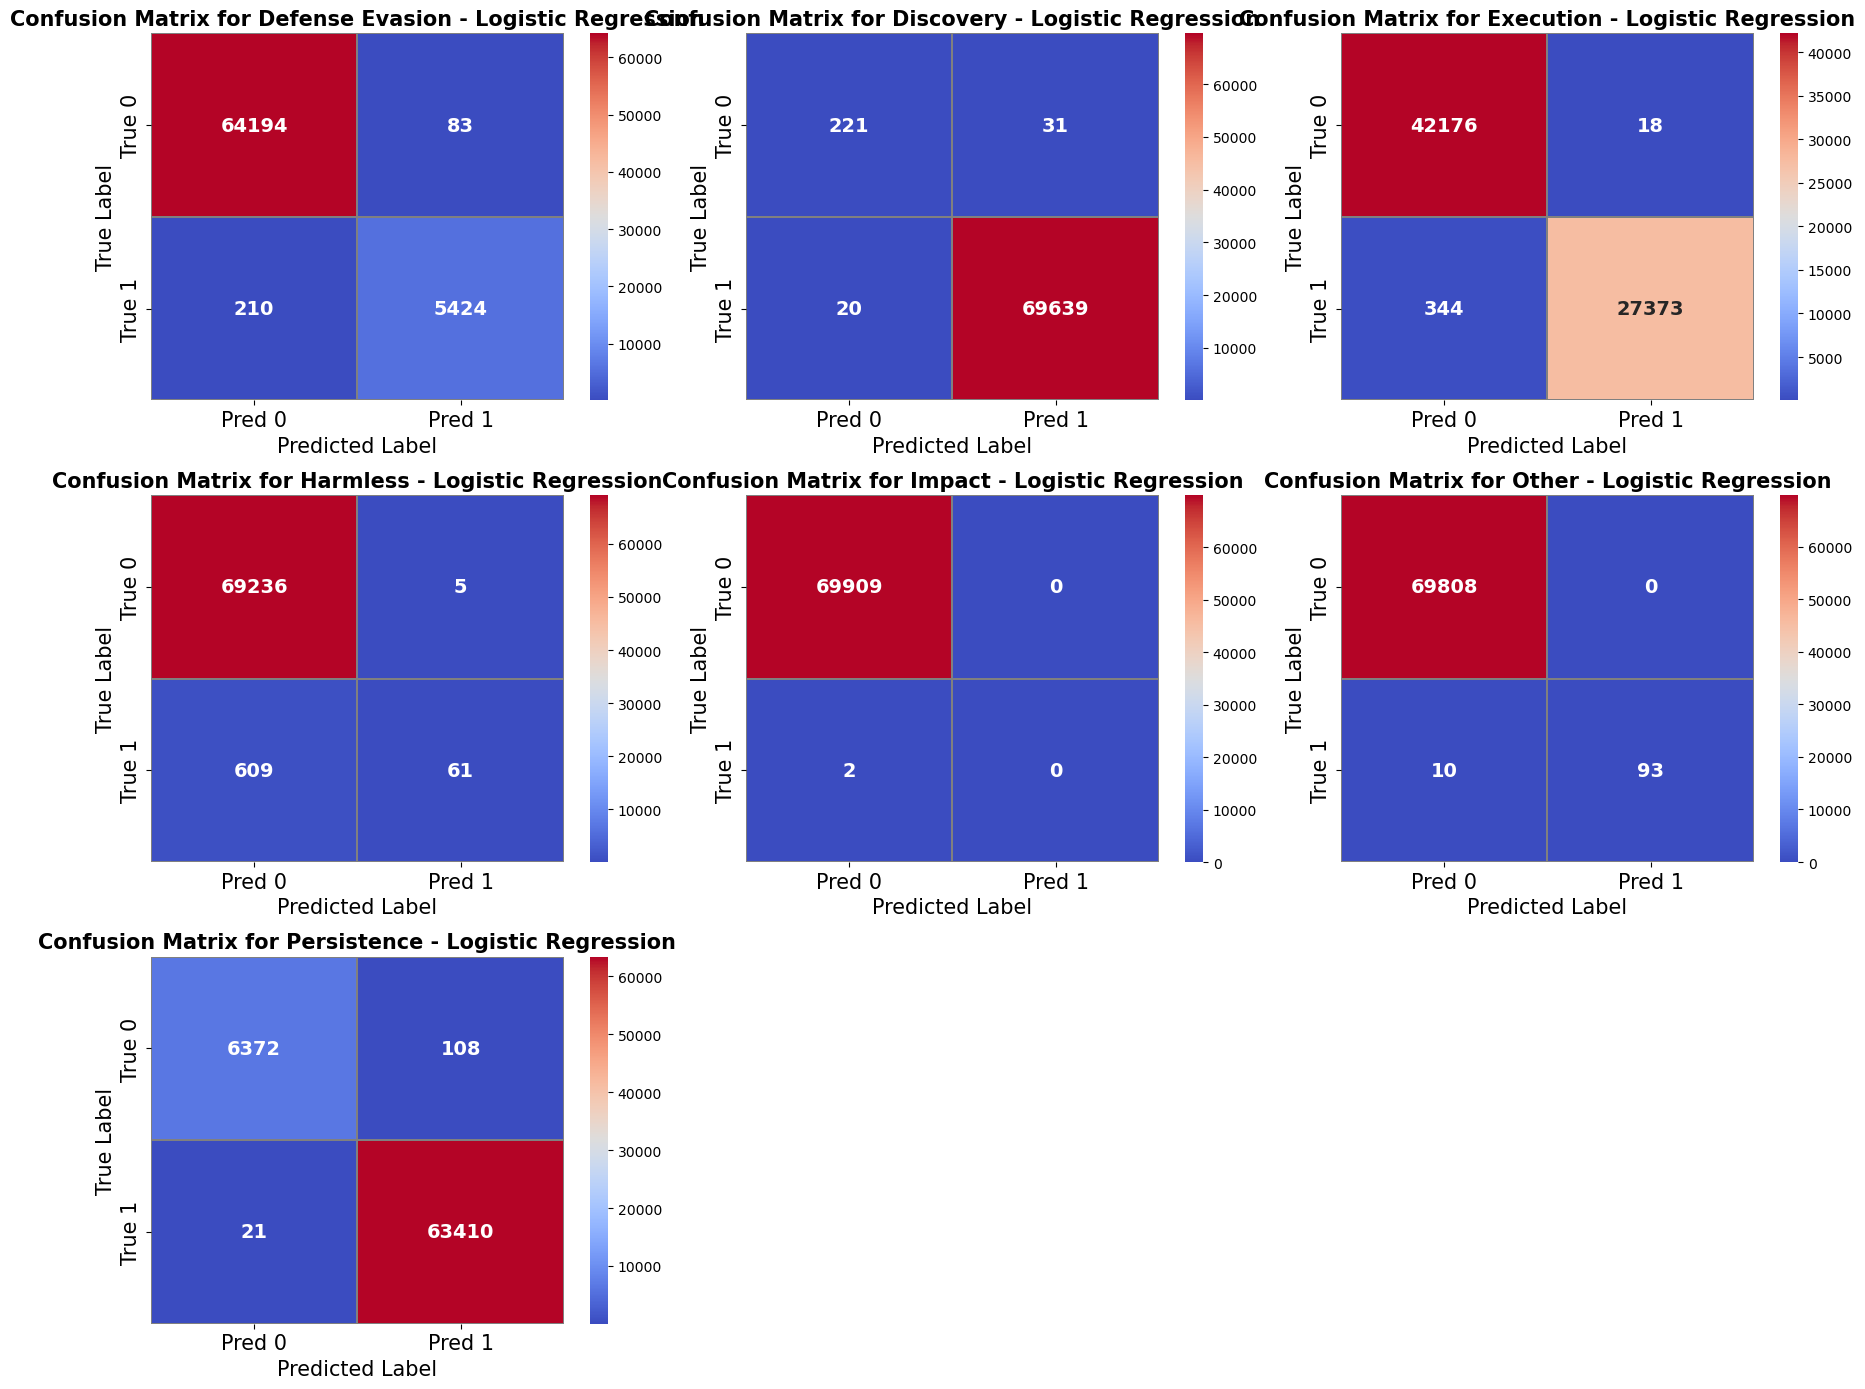


PERFORMANCE ON TRAIN SET: Logistic Regression

              Model   Set          Attack  Precision   Recall  F1-Score  Accuracy  Execution Time (s)
Logistic Regression Train Defense Evasion   0.991190 0.983378  0.987246  0.996193                 NaN
Logistic Regression Train       Discovery   0.949198 0.938678  0.943875  0.999136                 NaN
Logistic Regression Train       Execution   0.996003 0.994221  0.995092  0.995298                 NaN
Logistic Regression Train        Harmless   0.978597 0.545883  0.581672  0.991418                 NaN
Logistic Regression Train          Impact   0.499923 0.500000  0.499962  0.999847                 NaN
Logistic Regression Train           Other   0.995137 0.959815  0.976821  0.999877                 NaN
Logistic Regression Train     Persistence   0.997701 0.991725  0.994691  0.998210                 NaN

PERFORMANCE ON TEST SET: Logistic Regression

              Model  Set          Attack  Precision   Recall  F1-Score  Accuracy  Executi

In [11]:
# Train and evaluate Logistic Regression
model_name = "Logistic Regression"
model = models[model_name]

# Chiamata alla funzione che restituisce i risultati e i DataFrame per train e test
model_results[model_name], performance_comparison_lr_train, performance_comparison_lr_test = train_and_evaluate(
    model, model_name, X_train_tfidf, X_test_tfidf, y_train_binary, y_test_binary
)

# Stampa la tabella dei risultati per il train set
print(f"\n{'='*69}\nPERFORMANCE ON TRAIN SET: {model_name}\n{'='*69}\n")
print(performance_comparison_lr_train.to_string(index=False, max_colwidth=20))

# Stampa la tabella dei risultati per il test set
print(f"\n{'='*69}\nPERFORMANCE ON TEST SET: {model_name}\n{'='*69}\n")
print(performance_comparison_lr_test.to_string(index=False, max_colwidth=20))

# Aggiungi i DataFrame alla lista delle performance
performance_summaries.append(performance_comparison_lr_train)
performance_summaries.append(performance_comparison_lr_test)

### Random Forest

- Training
- Evaluation (confusion matrix and classification report)

[No Overfitting] Random Forest - Label: Defense Evasion

[No Overfitting] Random Forest - Label: Discovery

[No Overfitting] Random Forest - Label: Execution

[No Overfitting] Random Forest - Label: Harmless

[No Overfitting] Random Forest - Label: Impact

[No Overfitting] Random Forest - Label: Other

[No Overfitting] Random Forest - Label: Persistence



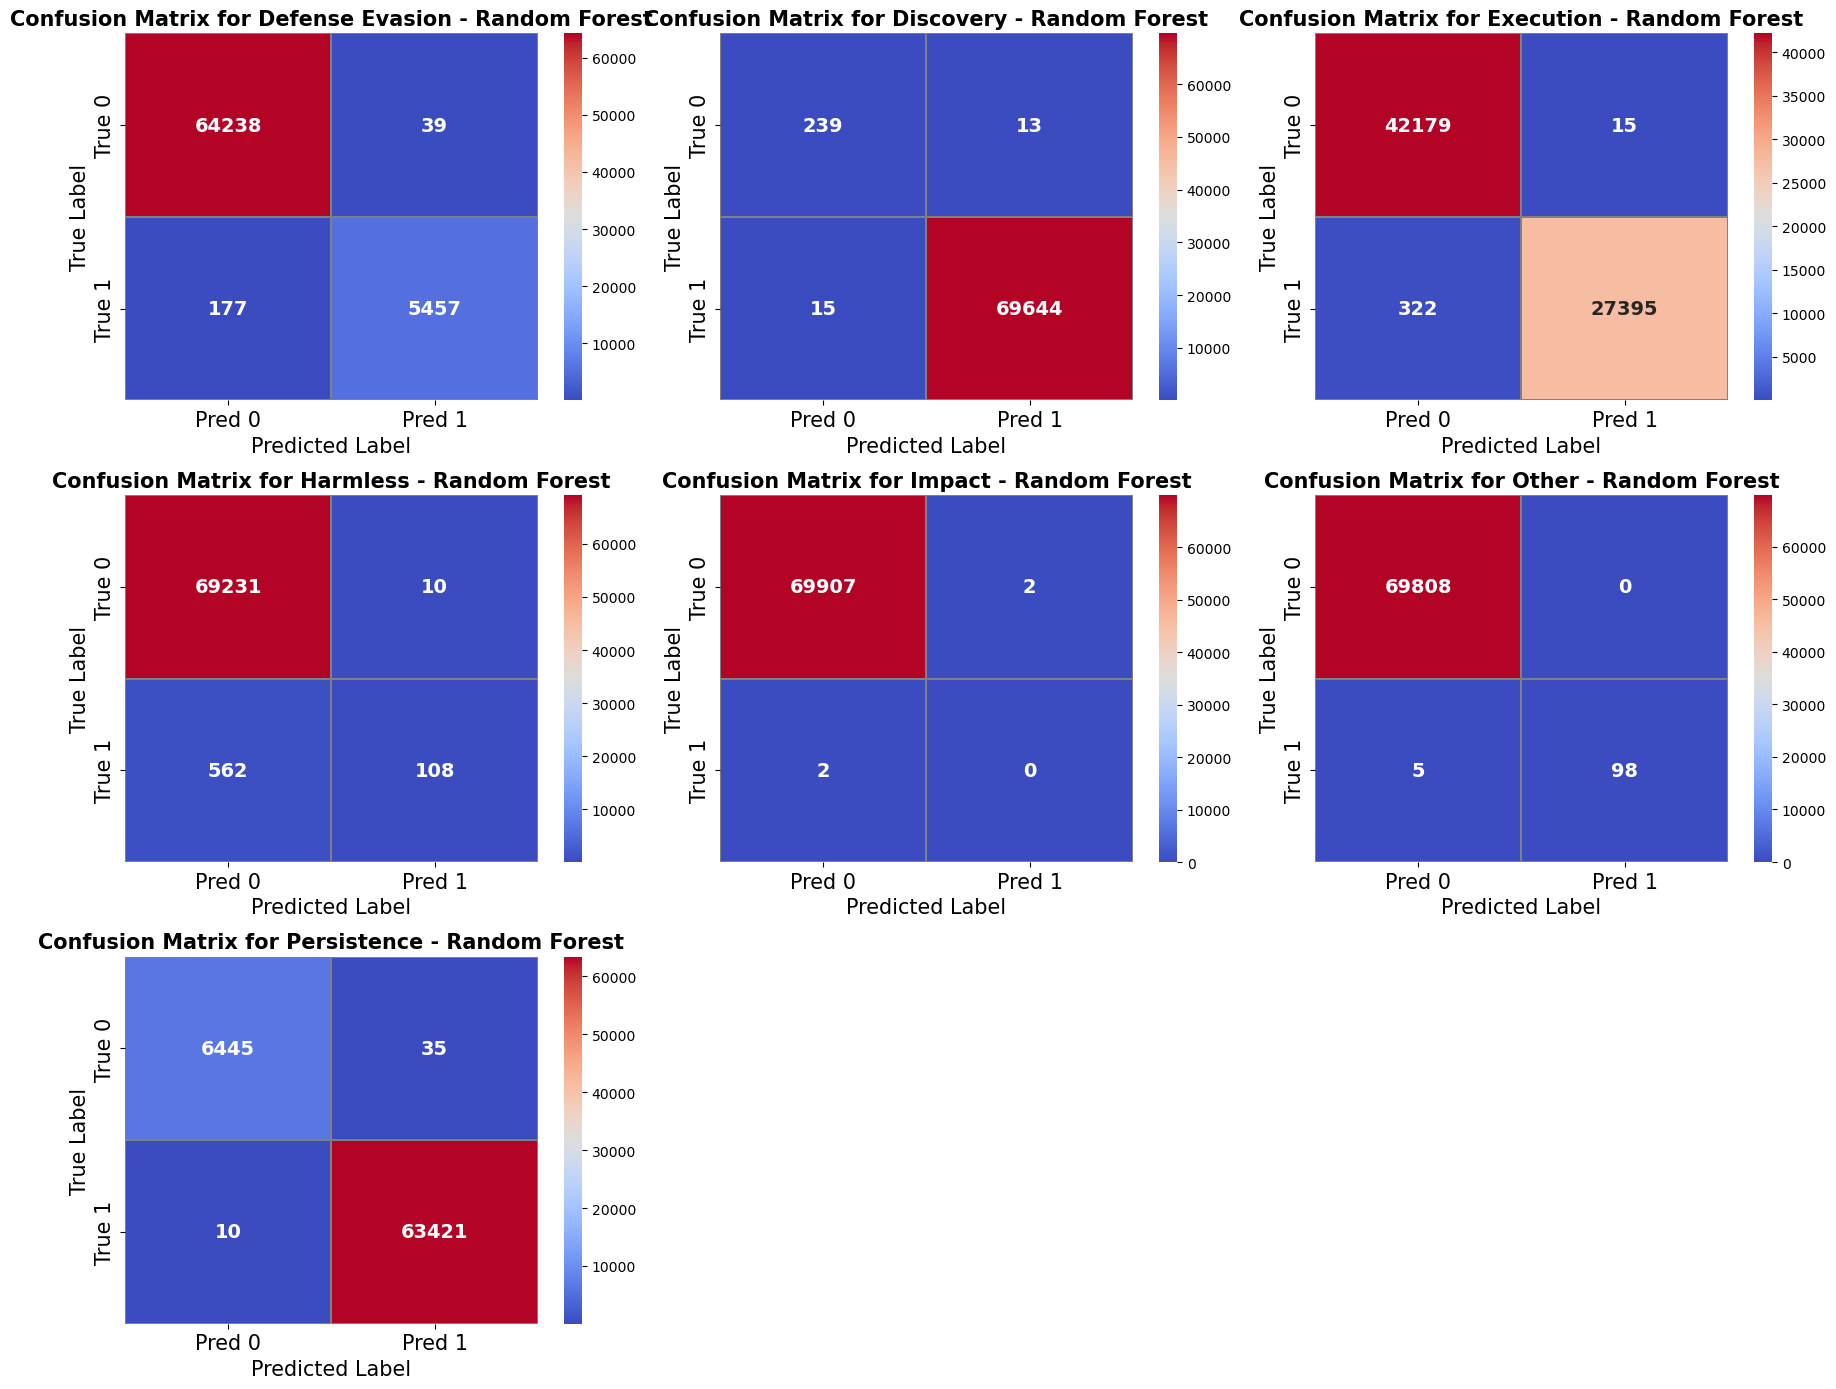


PERFORMANCE ON TRAIN SET: Random Forest

        Model   Set          Attack  Precision   Recall  F1-Score  Accuracy  Execution Time (s)
Random Forest Train Defense Evasion   0.996443 0.986883  0.991606  0.997499                 NaN
Random Forest Train       Discovery   0.995269 0.994496  0.994882  0.999920                 NaN
Random Forest Train       Execution   0.996632 0.994922  0.995758  0.995936                 NaN
Random Forest Train        Harmless   0.962743 0.595313  0.656430  0.992251                 NaN
Random Forest Train          Impact   0.999994 0.960000  0.979164  0.999988                 NaN
Random Forest Train           Other   0.999994 0.995536  0.997755  0.999988                 NaN
Random Forest Train     Persistence   0.999491 0.997905  0.998697  0.999559                 NaN

PERFORMANCE ON TEST SET: Random Forest

        Model  Set          Attack  Precision   Recall  F1-Score  Accuracy  Execution Time (s)
Random Forest Test Defense Evasion   0.995078 0.983988

In [12]:
# Train and evaluate Random Forest
model_name = "Random Forest"
model = models[model_name]

# Chiamata alla funzione che restituisce i risultati e i DataFrame per train e test
model_results[model_name], performance_comparison_rf_train, performance_comparison_rf_test = train_and_evaluate(
    model, model_name, X_train_tfidf, X_test_tfidf, y_train_binary, y_test_binary
)

# Stampa la tabella dei risultati per il train set
print(f"\n{'='*69}\nPERFORMANCE ON TRAIN SET: {model_name}\n{'='*69}\n")
print(performance_comparison_rf_train.to_string(index=False, max_colwidth=20))

# Stampa la tabella dei risultati per il test set
print(f"\n{'='*69}\nPERFORMANCE ON TEST SET: {model_name}\n{'='*69}\n")
print(performance_comparison_rf_test.to_string(index=False, max_colwidth=20))

# Aggiungi i DataFrame alla lista delle performance
performance_summaries.append(performance_comparison_rf_train)
performance_summaries.append(performance_comparison_rf_test)

### Support Vector Machine (SVM)

- Training
- Evaluation (confusion matrix and classification report)

[No Overfitting] SVM - Label: Defense Evasion

[No Overfitting] SVM - Label: Discovery

[No Overfitting] SVM - Label: Execution

[No Overfitting] SVM - Label: Harmless

[No Overfitting] SVM - Label: Impact

[No Overfitting] SVM - Label: Other

[No Overfitting] SVM - Label: Persistence



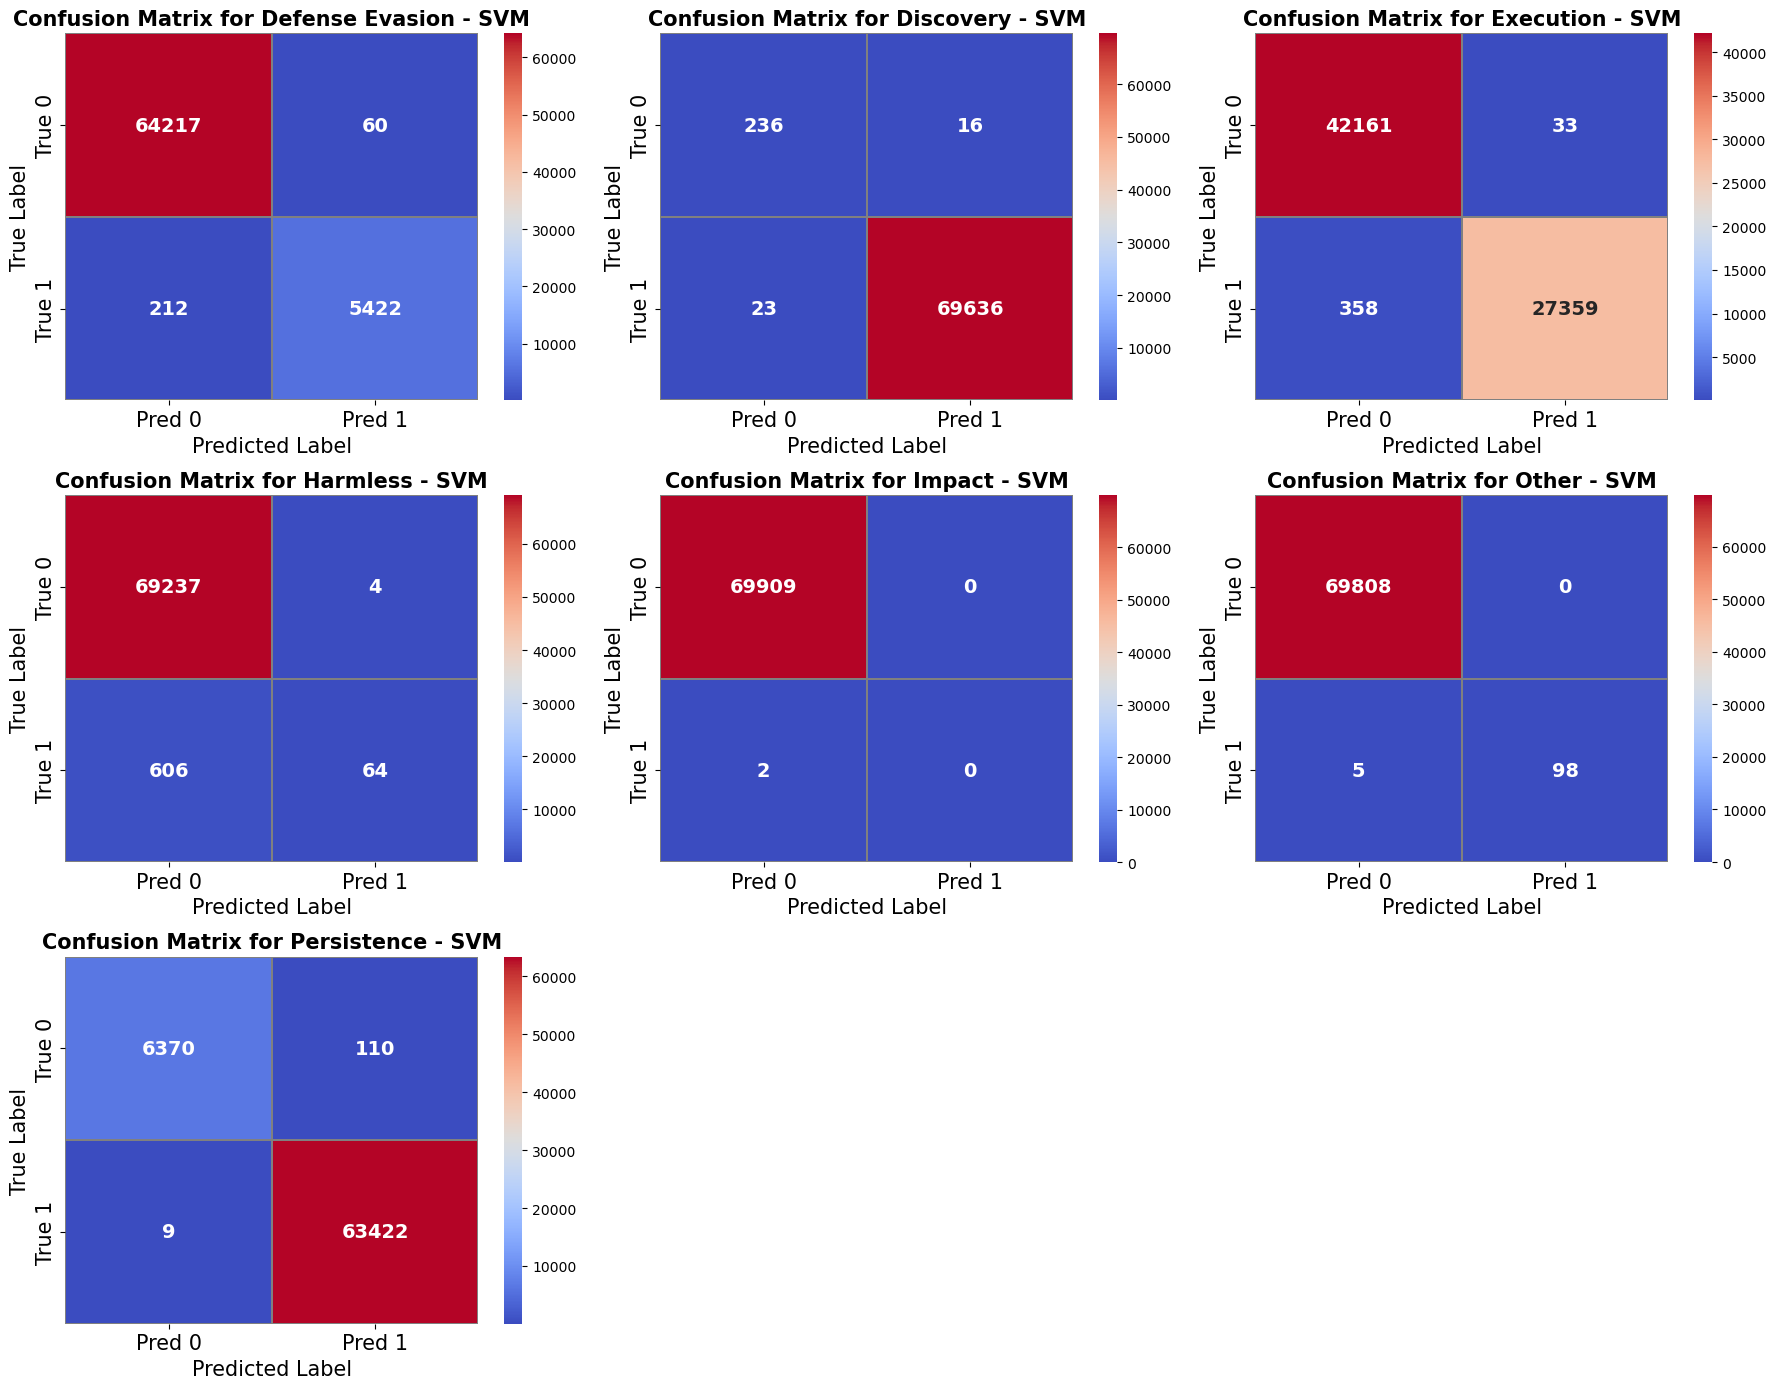


PERFORMANCE ON TRAIN SET: SVM

Model   Set          Attack  Precision   Recall  F1-Score  Accuracy  Execution Time (s)
  SVM Train Defense Evasion   0.993119 0.983252  0.988125  0.996463                 NaN
  SVM Train       Discovery   0.948790 0.974709  0.961383  0.999381                 NaN
  SVM Train       Execution   0.995573 0.993769  0.994651  0.994875                 NaN
  SVM Train        Harmless   0.978951 0.546860  0.583308  0.991436                 NaN
  SVM Train          Impact   0.499923 0.500000  0.499962  0.999847                 NaN
  SVM Train           Other   0.999963 0.973214  0.986220  0.999926                 NaN
  SVM Train     Persistence   0.998469 0.992160  0.995289  0.998412                 NaN

PERFORMANCE ON TEST SET: SVM

Model  Set          Attack  Precision   Recall  F1-Score  Accuracy  Execution Time (s)
  SVM Test Defense Evasion   0.992882 0.980719  0.986709  0.996109          525.847160
  SVM Test       Discovery   0.955484 0.968089  0.961700  0

In [13]:
# Train and evaluate SVM 
model_name = "SVM"
model = models[model_name]

# Chiamata alla funzione che restituisce i risultati e i DataFrame per train e test
model_results[model_name], performance_comparison_svm_train, performance_comparison_svm_test = train_and_evaluate(
    model, model_name, X_train_tfidf, X_test_tfidf, y_train_binary, y_test_binary
)

# Stampa la tabella dei risultati per il train set
print(f"\n{'='*69}\nPERFORMANCE ON TRAIN SET: {model_name}\n{'='*69}\n")
print(performance_comparison_svm_train.to_string(index=False, max_colwidth=20))

# Stampa la tabella dei risultati per il test set
print(f"\n{'='*69}\nPERFORMANCE ON TEST SET: {model_name}\n{'='*69}\n")
print(performance_comparison_svm_test.to_string(index=False, max_colwidth=20))

# Aggiungi i DataFrame alla lista delle performance
performance_summaries.append(performance_comparison_svm_train)
performance_summaries.append(performance_comparison_svm_test)

### Compare performances

"Do you observe overfitting or under-fitting? Which model generates the best performance?"

- text
- text

In [14]:
def compare_train_test(performance_summaries):
    """
    Compare models by calculating and displaying mean metrics for train and test sets separately.
    Adds average execution time per model.
    """
    train_summaries = []
    test_summaries = []

    # Itera su ciascun modello per raccogliere i risultati
    for idx, summary in enumerate(performance_summaries):
        model_name = summary["Model"].iloc[0]  # Assumiamo che ogni summary abbia la stessa 'Model' per ogni label

        if idx % 2 == 0: 
            # Filtra i risultati per il train set e calcola la media delle colonne numeriche
            train_metrics = summary[summary["Set"] == "Train"].select_dtypes(include='number').mean().to_dict()
            train_metrics["Model"] = model_name
            train_summaries.append(train_metrics)
        else: 
            # Filtra i risultati per il test set e calcola la media delle colonne numeriche
            test_metrics = summary[summary["Set"] == "Test"].select_dtypes(include='number').mean().to_dict()
            test_metrics["Model"] = model_name
            test_summaries.append(test_metrics)


    # Crea DataFrame per le tabelle train e test
    train_df = pd.DataFrame(train_summaries)
    test_df = pd.DataFrame(test_summaries)

    # Calcola la media del tempo di esecuzione (solo sul test set)
    avg_test_time = test_df["Execution Time (s)"].mean()

    # Aggiungi la media del tempo alla stampa
    print(f"Average Test Time: {avg_test_time:.4f} seconds")

    # Ordina le colonne mettendo "Model" per prima
    cols_train = ["Model"] + [col for col in train_df.columns if col != "Model"]
    train_df = train_df[cols_train]

    cols_test = ["Model"] + [col for col in test_df.columns if col != "Model"]
    test_df = test_df[cols_test]

    # Stampa i risultati
    print(f"\n{'='*69}\nTRAIN SET COMPARISON \n{'='*69}\n")
    print(train_df.to_string(index=False, max_colwidth=20))  # Tabella per il train set

    print(f"\n{'='*69}\nTEST SET COMPARISON \n{'='*69}\n")
    print(test_df.to_string(index=False, max_colwidth=20))  # Tabella per il test set


In [15]:
# Compare models
compare_train_test(performance_summaries)

Average Test Time: 60.6992 seconds

TRAIN SET COMPARISON 

              Model  Precision   Recall  F1-Score  Accuracy  Execution Time (s)
Logistic Regression   0.915393 0.844814  0.854194  0.997140                 NaN
      Random Forest   0.992938 0.932151  0.944899  0.997877                 NaN
                SVM   0.916398 0.851995  0.858420  0.997191                 NaN

TEST SET COMPARISON 

              Model  Precision   Recall  F1-Score  Accuracy  Execution Time (s)
Logistic Regression   0.914275 0.843013  0.853998  0.997015            1.406082
      Random Forest   0.916271 0.857937  0.868179  0.997534           23.029177
                SVM   0.915455 0.850980  0.858503  0.997062          157.662214


<center><b><font size=5>Hyperparameter Tuning<b><center>

Fine-tune the hyperparameters of the ML models using cross-validation.

"Tune the hyper-parameters of the models through cross-validation. How do performance vary?"

**Steps:**

TO BE CHECKED

- Use GridSearchCV to tune hyperparameters.
- Evaluate the performance of the tuned models.
- Compare the results with baseline performance.

### text

- text
- text

In [16]:
param_grid_logreg = {
    'estimator__C': [0.1, 1, 10],
    'estimator__solver': ['liblinear', 'saga'],
    'estimator__max_iter': [1000]
}

param_grid_rf = {
    'estimator__n_estimators': [50, 100, 150],
    'estimator__max_depth': [10, 20, 30, None],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4],
    'estimator__random_state': [42]
}

param_grid_svm = {
    'estimator__C': [0.1, 1, 10],
    'estimator__kernel': ['linear', 'rbf', 'poly'],
    'estimator__gamma': ['scale', 'auto'],
    'estimator__degree': [3, 4, 5],
    'estimator__random_state': [42]
}

In [17]:
# Funzione per eseguire il GridSearch
def hyperparameter_tuning_with_gridsearch(model_name, model, param_grid, X_train, y_train_binary):
    """
    Esegui il GridSearchCV per ottimizzare gli iperparametri del modello.
    Utilizza OneVsRestClassifier per la classificazione multilabel.
    """
    ovr_model = OneVsRestClassifier(model)
    
    grid_search = GridSearchCV(estimator=ovr_model, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1, scoring='f1_macro')  # Usa f1_macro per le prestazioni multilabel,
    #accuracy alta ma f1_score vede se anche le claasi minoritarie sono state predette correttamente. Migliore per dataset sbilanciati
    
    print(f"\nTuning hyperparameters for {model_name}...")
    
    grid_search.fit(X_train, y_train_binary)
    
    print(f"\nBest parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best cross-validation score for {model_name}: {grid_search.best_score_}")
    
    return grid_search.best_estimator_

In [18]:
# Esegui GridSearch per Logistic Regression con OneVsRestClassifier
best_logreg_model = hyperparameter_tuning_with_gridsearch(
    "Logistic Regression", LogisticRegression(max_iter=1000, random_state=42), param_grid_logreg, X_train_tfidf, y_train_binary
)


Tuning hyperparameters for Logistic Regression...
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Best parameters for Logistic Regression: {'estimator__C': 10, 'estimator__max_iter': 1000, 'estimator__solver': 'saga'}
Best cross-validation score for Logistic Regression: 0.7314750837156205


In [19]:
# Esegui GridSearch per Random Forest con OneVsRestClassifier
best_rf_model = hyperparameter_tuning_with_gridsearch(
    "Random Forest", RandomForestClassifier(random_state=42), param_grid_rf, X_train_tfidf, y_train_binary
)


Tuning hyperparameters for Random Forest...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best parameters for Random Forest: {'estimator__max_depth': 20, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 50, 'estimator__random_state': 42}
Best cross-validation score for Random Forest: 0.802776695163608


In [ ]:
# Esegui GridSearch per SVM con OneVsRestClassifier
best_svm_model = hyperparameter_tuning_with_gridsearch(
    "SVM", SVC(random_state=42), param_grid_svm, X_train_tfidf, y_train_binary
)


Tuning hyperparameters for SVM...
Fitting 5 folds for each of 54 candidates, totalling 270 fits


/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


### text

- text
- text

In [ ]:
def evaluate_model(model, X_test, y_test, model_name, X_train, y_train):
    """
    Valuta un modello su un set di test, gestisce i warning e visualizza le metriche.
    """
    print(f"\n--- Evaluation for {model_name} ---")

    # Conversione di y_test in array NumPy se è un DataFrame
    if isinstance(y_test, pd.DataFrame):
        y_test = y_test.values
    if isinstance(y_train, pd.DataFrame):
        y_train = y_train.values

    # Predizioni
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Controllo delle dimensioni di y_test e y_pred
    if y_test.shape != y_pred_test.shape:
        raise ValueError("Mismatch between y_test and y_pred shapes.")
    
    # Controllo delle classi predette e reali
    predicted_classes_test = np.unique(y_pred_test.argmax(axis=1))
    actual_classes_test = np.unique(y_test.argmax(axis=1))
    print("Unique predicted classes (Test):", predicted_classes_test)
    print("Unique actual classes (Test):", actual_classes_test)

    # Segnalare classi non predette
    missing_classes_test = set(range(y_test.shape[1])) - set(predicted_classes_test)
    if missing_classes_test:
        print(f"Warning: The following classes were not predicted in Test: {missing_classes_test}\n")

    # Matrice di confusione normalizzata
    cm_normalized = confusion_matrix(y_test.argmax(axis=1), y_pred_test.argmax(axis=1), normalize='true')
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_normalized, annot=True, cmap="Blues", fmt=".2f")
    plt.title(f"{model_name} - Normalized Confusion Matrix (Test)")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

    # Matrice di confusione non normalizzata
    cm_raw = confusion_matrix(y_test.argmax(axis=1), y_pred_test.argmax(axis=1))
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_raw, annot=True, cmap="Blues", fmt="d")
    plt.title(f"{model_name} - Raw Confusion Matrix (Test)")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

    # Metriche di valutazione per Test
    report_test = classification_report(y_test, y_pred_test, output_dict=True, zero_division=0)
    precision_test = report_test['macro avg']['precision']
    recall_test = report_test['macro avg']['recall']
    f1_test = report_test['macro avg']['f1-score']
    
    print(f"\n{'='*69}\nTest Classification Report (per class): {model_name}\n{'='*69}\n")
    print(classification_report(y_test, y_pred_test, zero_division=0))
    
    print(f"Test Precision (macro): {precision_test:.4f}")
    print(f"Test Recall (macro): {recall_test:.4f}")
    print(f"Test F1 Score (macro): {f1_test:.4f}\n")
    
    # Metriche di valutazione per Train
    report_train = classification_report(y_train, y_pred_train, output_dict=True, zero_division=0)
    precision_train = report_train['macro avg']['precision']
    recall_train = report_train['macro avg']['recall']
    f1_train = report_train['macro avg']['f1-score']

    
    print(f"\n{'='*69}\nTrain Classification Report (per class): {model_name}\n{'='*69}\n")
    print(classification_report(y_train, y_pred_train, zero_division=0))
    
    print(f"Train Precision (macro): {precision_train:.4f}")
    print(f"Train Recall (macro): {recall_train:.4f}")
    print(f"Train F1 Score (macro): {f1_train:.4f}\n")

In [ ]:
# Esegui l'evaluazione del modello per Logistic Regression
evaluate_model(
    best_logreg_model,
    X_test_tfidf,
    y_test_binary,
    "Logistic Regression",
    X_train_tfidf,
    y_train_binary
)

In [ ]:
# Esegui l'evaluazione del modello per Random Forest
evaluate_model(
    best_rf_model,
    X_test_tfidf,
    y_test_binary,
    "Random Forest",
    X_train_tfidf,
    y_train_binary
)

In [ ]:
# Esegui l'evaluazione del modello per SVM
evaluate_model(
    best_svm_model,
    X_test_tfidf,
    y_test_binary,
    "SVM",
    X_train_tfidf,
    y_train_binary
)

### text

- text
- text

In [ ]:
# Funzione per valutare i modelli base e ottimizzati
def compare_models(base_model, tuned_model, X_test, y_test, model_name):
    """
    Confronta le performance di un modello base e di un modello ottimizzato.
    """
    print(f"\n=== {model_name} Comparison ===")
    
    # Conversione di y_test in array NumPy se necessario
    if isinstance(y_test, pd.DataFrame):
        y_test = y_test.to_numpy()  # Converti da DataFrame a NumPy array
    y_test = y_test.argmax(axis=1)  # Converti da one-hot encoding a etichette

    # Predizioni per il modello base
    base_pred = base_model.predict(X_test)
    if len(base_pred.shape) > 1:  # Se le predizioni sono in formato one-hot
        base_pred = base_pred.argmax(axis=1)

    base_f1 = f1_score(y_test, base_pred, average='macro', zero_division=0)

    # Predizioni per il modello ottimizzato
    tuned_pred = tuned_model.predict(X_test)
    if len(tuned_pred.shape) > 1:  # Se le predizioni sono in formato one-hot
        tuned_pred = tuned_pred.argmax(axis=1)

    tuned_f1 = f1_score(y_test, tuned_pred, average='macro', zero_division=0)

    print(f"Base Model F1 Score: {base_f1:.4f}")
    print(f"Tuned Model F1 Score: {tuned_f1:.4f}")

    # Calcola il miglioramento percentuale
    improvement_percentage = ((tuned_f1 - base_f1) / base_f1) * 100 if base_f1 != 0 else float('inf')
    print(f"Improvement in F1 Score: {improvement_percentage:.2f}%\n")
    
    # Matrice di confusione per entrambi i modelli
    cm_base = confusion_matrix(y_test, base_pred)
    cm_tuned = confusion_matrix(y_test, tuned_pred)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.heatmap(cm_base, annot=True, cmap="Blues", fmt="d", cbar=False)
    plt.title(f"{model_name} - Base Model Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    
    plt.subplot(1, 2, 2)
    sns.heatmap(cm_tuned, annot=True, cmap="Blues", fmt="d", cbar=False)
    plt.title(f"{model_name} - Tuned Model Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    
    plt.tight_layout()
    plt.show()

    # Visualizza le metriche per entrambi i modelli
    metrics = ["Precision", "Recall", "F1 Score"]
    base_metrics = [
        precision_score(y_test, base_pred, average='macro', zero_division=0),
        recall_score(y_test, base_pred, average='macro', zero_division=0),
        base_f1
    ]
    tuned_metrics = [
        precision_score(y_test, tuned_pred, average='macro', zero_division=0),
        recall_score(y_test, tuned_pred, average='macro', zero_division=0),
        tuned_f1
    ]
    
    # Plot confronto tra i due modelli
    x = np.arange(len(metrics))
    width = 0.35
    
    plt.figure(figsize=(8, 6))
    plt.bar(x - width/2, base_metrics, width, label="Base Model", color='lightblue')
    plt.bar(x + width/2, tuned_metrics, width, label="Tuned Model", color='orange')
    plt.xticks(x, metrics)
    plt.title(f"{model_name} - Metrics Comparison")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

In [ ]:
compare_models(models["Logistic Regression"], best_logreg_model, X_test_tfidf, y_test_binary, "Logistic Regression")

In [ ]:
compare_models(models["Random Forest"], best_rf_model, X_test_tfidf, y_test_binary, "Random Forest")

In [ ]:
compare_models(models["SVM"], best_svm_model, X_test_tfidf, y_test_binary, "SVM")

<center><b><font size=5>Result Analysis<b><center>

Analyze and summarize the results for each intent.

"Comments on the results for each on the intents."

**Steps:**

- Compare confusion matrices and classification reports.
- Highlight trends and insights for each intent.
- Summarize findings and discuss implications.

### text

- text
- text

<center><b><font size=5>Feature Experimentation<b><center>

Explore the impact of different features on model performance.

"Explore the possible features: try combining features differently, e.g., does tf-idf improve or worsen
performance? Think about the problem and summarize the ways you have tried (even those that
did not work)."

**Steps:**

- Experiment with feature combinations (e.g., adding temporal features).
- Observe performance changes with each combination.
- Document successful and unsuccessful experiments.

### text

- text
- text